In [21]:
from __future__ import print_function, division, unicode_literals
import six
import os
from os.path import join
import json
from codecs import open
from collections import defaultdict
from operator import itemgetter
import nltk
import numpy as np
from nltk.corpus import stopwords
import re
import codecs

from sklearn.cross_validation import KFold

In [22]:
DATA_DIR = join(os.environ['HOME'], 'data/allen-ai-challenge')

TRAINING = True
LUCENE_VEC_DIM = 7

TRAINING_SET = join(DATA_DIR, 'training_set.tsv')

if TRAINING:
    LUCENE_FILE = join(DATA_DIR, 'features', 'lucene_vecs%d.tsv' % LUCENE_VEC_DIM)
    W2V_FILE = join(DATA_DIR, 'features', 'w2f.tsv')
else:
    LUCENE_FILE = join(DATA_DIR, 'features', 'lucene_vecs%d_submission.tsv' % LUCENE_VEC_DIM)
    W2V_FILE = join(DATA_DIR, 'features', 'w2f_validate.tsv')

SUMBISSION_FILE = join(DATA_DIR, 'submissions', 'vec25_gamma222.csv')

In [23]:
import theano
import theano.tensor as T

In [24]:
all_x = []
all_y = []
all_qid = []
with open(LUCENE_FILE, encoding='utf8') as f:
    for row in (line.strip().split('\t') for line in f):
        all_qid.append(row[0])
        correct = row[1]
        vecs = np.vstack([np.fromstring(r, sep=';') for r in row[2:6]])
        
        all_x.append(vecs)
        y_vec = np.zeros(4, dtype=int)
        if correct in 'ABCD':
             y_vec['ABCD'.index(correct)] = 1
        all_y.append(y_vec)
all_x = np.array(all_x)
all_y = np.array(all_y)


In [47]:
idx_train, idx_valid = next(iter(KFold(all_x.shape[0], 5, shuffle=True)))
print(all_x.shape)
print(W2V.shape)

(2500, 4, 7)
(2500, 4)


In [48]:
import lasagne
D = all_x.shape[2]

L2_REG = 1e+0

def l2_to1(x):
    return T.mean((x-1)**2)

lin = lasagne.layers.InputLayer((None, D))  # (4b, 10)
n = lasagne.layers.DenseLayer(lin, 1, b=None, W=lasagne.init.Constant(1),
                              nonlinearity=lasagne.nonlinearities.elu)  # (4b, 1)
n = lasagne.layers.ReshapeLayer(n, (-1, 4))  # (b, 4)

t_raw_output = lasagne.layers.get_output(n)

n1 = lasagne.layers.NonlinearityLayer(n, nonlinearity=lasagne.nonlinearities.softmax)

t_output = lasagne.layers.get_output(n1)
params = lasagne.layers.get_all_params(n1)

var_targets = T.imatrix()
t_nll = lasagne.objectives.categorical_crossentropy(t_output, var_targets).mean()
t_reg_loss = lasagne.regularization.regularize_network_params(n, l2_to1) * L2_REG
t_acc = lasagne.objectives.categorical_accuracy(t_output, var_targets).mean()
updates = lasagne.updates.adam(t_nll + t_reg_loss, params)
# updates = lasagne.updates.nesterov_momentum(t_nll + t_reg_loss, params, learning_rate=1e-3, momentum=0.9)

train_fn = theano.function([lin.input_var, var_targets], t_nll, updates=updates)
cost_fn = theano.function([lin.input_var, var_targets], t_nll)
acc_fn = theano.function([lin.input_var, var_targets], t_acc)
forward_fn = theano.function([lin.input_var], t_raw_output)

In [49]:
def randomize(x, y, randomize=True):
    new_x = np.zeros((x.shape[0] * 4, x.shape[2]))
    new_y = np.zeros_like(y)
    for i in range(x.shape[0]):
        keys = np.arange(4)
        if randomize:
            np.random.shuffle(keys)
        for j, k in enumerate(keys):
            new_x[i*4 + k] = x[i, j]
            new_y[i, k] = y[i, j]
    return new_x, new_y.astype('int32')

BATCH = 200
EPOCHS = 200
accuracies = [0]
for e in range(EPOCHS):
    np.random.shuffle(idx_train)
    for i in range(0, idx_train.shape[0], BATCH):
        keys = idx_train[i:i+BATCH]
        batch_x = all_x[keys]
        batch_y = all_y[keys]
        bx, by = randomize(batch_x, batch_y)
        loss = train_fn(bx, by)
#         print(loss)
    bx, by = randomize(all_x[idx_valid], all_y[idx_valid])
    acc = acc_fn(bx, by)
    print(e, cost_fn(bx, by), acc)
#     if accuracies[-1] > acc + 0.005 and acc > accuracies[1]:
#         break
#     accuracies.append(acc)
    

0 2.9117148796 0.422
1 2.88829792275 0.416
2 2.86463200064 0.422
3 2.84142113789 0.418
4 2.81845641181 0.42
5 2.79545273099 0.42
6 2.77246809464 0.42
7 2.74998027711 0.418
8 2.72728790966 0.416
9 2.70485192273 0.418
10 2.68290658255 0.418
11 2.66116309546 0.422
12 2.63937378165 0.414
13 2.61780404743 0.42
14 2.59673432093 0.416
15 2.57543297601 0.42
16 2.55471316998 0.416
17 2.53386949822 0.416
18 2.51365250835 0.416
19 2.49362733553 0.42
20 2.47283128348 0.422
21 2.45286879693 0.416
22 2.43327896171 0.422
23 2.41382210127 0.42
24 2.39400823186 0.418
25 2.37483511443 0.42
26 2.35606095014 0.418
27 2.33748595302 0.42
28 2.31874722661 0.42
29 2.30032859339 0.418
30 2.28253668408 0.42
31 2.26472407696 0.418
32 2.24670253479 0.416
33 2.22925626374 0.414
34 2.21222848987 0.422
35 2.1956607717 0.422
36 2.17877865583 0.416
37 2.16191787489 0.414
38 2.14584700503 0.416
39 2.12957756895 0.414
40 2.11380694518 0.422
41 2.09804977513 0.418
42 2.08248168357 0.418
43 2.06684932404 0.416
44 2.052271

In [50]:
params[0].get_value()

array([[ 0.81096655],
       [ 0.64290876],
       [ 0.49371577],
       [ 0.36486337],
       [ 0.25365207],
       [ 0.15816062],
       [ 0.07998841]])

In [51]:
# forward_fn(bx)[0], by[0]
acc_fn(bx, by)

array(0.412)

In [52]:
cost_fn(bx, by)

array(1.4644893825356606)

In [53]:
# W = params[0].get_value()[:,0]
# # W = np.ones_like(W)
# # W[0] = 2
# print(W)

def norm_softmax(data):
    s = data.sum(axis=1, keepdims=True)
    normalized = data/s
    exps = np.exp(normalized)
    return exps / exps.sum(axis=1, keepdims=True) 

def softmax(data):
    exps = np.exp(data)
    return exps / exps.sum(axis=1, keepdims=True)

# def softmax(x):
#     e_x = np.exp(x - x.max(axis=1, keepdims=True))
#     return e_x / e_x.sum(axis=1, keepdims=True)


In [54]:
res = []
bx, by = randomize(all_x[idx_valid], all_y[idx_valid], randomize=False)

lucene_output = forward_fn(bx)

In [55]:
res = []
bx, by = randomize(all_x[idx_valid], all_y[idx_valid], randomize=False)
lucene_output = forward_fn(bx)

gammas = np.linspace(0, 1, 100)
for gamma  in gammas:
    overall_output = softmax(lucene_output)*gamma + norm_softmax(W2V[idx_valid])*(1-gamma)
    acc = (by.argmax(axis=1) == overall_output.argmax(axis=1)).sum() / by.shape[0]
    print(gamma, 'Overall accuracy', acc)
    res.append(acc)

0.0 Overall accuracy 0.372
0.010101010101 Overall accuracy 0.396
0.020202020202 Overall accuracy 0.396
0.030303030303 Overall accuracy 0.41
0.040404040404 Overall accuracy 0.41
0.0505050505051 Overall accuracy 0.418
0.0606060606061 Overall accuracy 0.422
0.0707070707071 Overall accuracy 0.426
0.0808080808081 Overall accuracy 0.424
0.0909090909091 Overall accuracy 0.426
0.10101010101 Overall accuracy 0.424
0.111111111111 Overall accuracy 0.422
0.121212121212 Overall accuracy 0.42
0.131313131313 Overall accuracy 0.416
0.141414141414 Overall accuracy 0.418
0.151515151515 Overall accuracy 0.422
0.161616161616 Overall accuracy 0.418
0.171717171717 Overall accuracy 0.42
0.181818181818 Overall accuracy 0.418
0.191919191919 Overall accuracy 0.422
0.20202020202 Overall accuracy 0.416
0.212121212121 Overall accuracy 0.412
0.222222222222 Overall accuracy 0.41
0.232323232323 Overall accuracy 0.41
0.242424242424 Overall accuracy 0.408
0.252525252525 Overall accuracy 0.408
0.262626262626 Overall acc

Best result 0.426 obtained for gamma=0.071


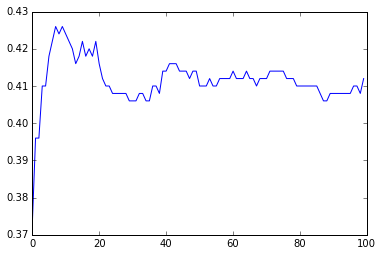

In [56]:
%matplotlib inline
from matplotlib.pyplot import *

best_acc, best_gamma = max(zip(res, gammas), key=itemgetter(0))
print('Best result %.3f obtained for gamma=%.3f' % (best_acc, best_gamma))
plot(res)

In [57]:
x.shape

(8, 7)

In [74]:
gamma = 0.75

bx, by = randomize(all_x, all_y, randomize=False)

with open(TRAINING_SET, encoding='utf8') as f_in:
    f_in.readline()
    with open(join(DATA_DIR, 'analyze_me.tsv'), encoding='utf8', mode='w') as f_out:
        print('# answers: lucene\tw2v\tcombined', file=f_out)
        print(file=f_out)
        for i, line in enumerate(f_in):
            qid, q, correct, A, B, C, D = line.strip().split('\t')
            x, y = randomize(all_x[i:i+1], all_y[i:i+1], randomize=False)

            answer_lucene = softmax(forward_fn(x))
            answer_w2v = norm_softmax(W2V[i:i+1])
            answer_combined = answer_lucene*gamma + answer_w2v*(1-gamma)
            print(qid, correct, sep='\t', file=f_out)
            print(q, file=f_out)
            for i, letter, answer_text in zip(xrange(4), 'ABCD', [A, B, C, D]):
                print(letter, '%.3f' % answer_lucene[0, i], 
                      '%.3f' % answer_w2v[0, i], 
                      '%.3f' % answer_combined[0, i], 
                      answer_text, sep='\t', file=f_out)
            print(file=f_out)
        
# lucene_output = softmax(forward_fn(bx))

# gamma = 0.222
# overall_output = overall_output = softmax(lucene_output)*gamma + norm_softmax(W2V)*(1-gamma)
# overall_answers = overall_output.argmax(axis=1)

# with open(SUMBISSION_FILE, mode='w') as f:
#     print('id,correctAnswer', file=f)
#     for i in range(by.shape[0]):
#         print(all_qid[i], 'ABCD'[overall_answers[i]], sep=',', file=f)

Submission
-----------


In [ ]:
gamma = 0.222


bx, by = randomize(all_x, all_y, randomize=False)
lucene_output = softmax(forward_fn(bx))

overall_output = overall_output = softmax(lucene_output)*gamma + norm_softmax(W2V)*(1-gamma)
overall_answers = overall_output.argmax(axis=1)

with open(SUMBISSION_FILE, mode='w') as f:
    print('id,correctAnswer', file=f)
    for i in range(by.shape[0]):
        print(all_qid[i], 'ABCD'[overall_answers[i]], sep=',', file=f)